# Example Notebook: Presidential party and real GDP

This notebook shows how to turn a political economy question into a testable hypothesis, find data, and test it empirically.

### 1. Research Question:
Does real GDP growth look different when Republicans control the White House compared with Democrats?

### 2. Testable hypothesis:
When the US has a Democratic president, real GDP growth is stronger than during Republican administrations.

In [15]:
# Load necessary libraries
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Import additional packages (e.g., numpy) here if your transformations require them

### 3. Finding Data using FRED
We now pull the series you want to study plus a presidential party flag so we can compare regimes.

In [16]:
# Set up FRED data connection
# Instructions for getting your FRED API key available at these websites
# https://pypi.org/project/fredapi/ 
# http://api.stlouisfed.org/api_key.html
from fredapi import Fred
fred = Fred(api_key='3a0ebd3c4baf668cb9f18d11334187fb')

# Choose the FRED series you want to analyze.
FRED_SERIES_ID = 'GDPC1'  # Real Gross Domestic Product, Chained 2017 Dollars
OBSERVATION_START = '1960-01-01'  # Adjust the time window as needed
OBSERVATION_END = '2025-12-31'

series_info = fred.get_series_info(FRED_SERIES_ID)
series_title = series_info.get('title', FRED_SERIES_ID) if hasattr(series_info, 'get') else FRED_SERIES_ID
series_units = series_info.get('units', '') if hasattr(series_info, 'get') else ''
analysis_label = f"{series_title} ({series_units})" if series_units else series_title

temp = fred.get_series(
    FRED_SERIES_ID,
    observation_start=OBSERVATION_START,
    observation_end=OBSERVATION_END,
)
df_series = (
    pd.DataFrame(data=temp, columns=['value'])
    .rename_axis('Date')
    .reset_index()
    .dropna()
)

period_index = pd.PeriodIndex(pd.to_datetime(df_series['Date']), freq='Q')
df_series['Date'] = period_index.to_timestamp(how='start')
df_series = df_series.sort_values('Date').reset_index(drop=True)

print(f"Loaded {FRED_SERIES_ID}: {analysis_label}")
print(df_series.head())
print(df_series.tail())

Loaded GDPC1: Real Gross Domestic Product (Billions of Chained 2017 Dollars)
        Date     value
0 1960-01-01  3517.181
1 1960-04-01  3498.246
2 1960-07-01  3515.385
3 1960-10-01  3470.278
4 1961-01-01  3493.703
          Date      value
257 2024-04-01  23286.508
258 2024-07-01  23478.570
259 2024-10-01  23586.542
260 2025-01-01  23548.210
261 2025-04-01  23770.976


In [17]:
# Transform the series for analysis - Calculate growth rates
ANALYSIS_COLUMN = 'real_gdp'  # Keep original GDP levels
GROWTH_COLUMN = 'gdp_growth_qoq'  # Quarterly growth rate
ANNUALIZED_GROWTH_COLUMN = 'gdp_growth_annualized'  # Annualized growth rate

full_periods = pd.period_range('1960Q1', '2025Q4', freq='Q')
df_series = (
    df_series.set_index(pd.PeriodIndex(df_series['Date'], freq='Q'))
    .reindex(full_periods)
)

df_series.index.name = 'Quarter'
df_series = df_series.reset_index()
df_series['Date'] = df_series['Quarter'].dt.to_timestamp(how='start')

# Keep original GDP levels
df_series[ANALYSIS_COLUMN] = df_series['value']

# Calculate quarterly growth rate (quarter-over-quarter)
df_series[GROWTH_COLUMN] = df_series['value'].pct_change() * 100

# Calculate annualized growth rate (quarterly rate * 4)
df_series[ANNUALIZED_GROWTH_COLUMN] = df_series[GROWTH_COLUMN] * 4

# Remove rows with missing growth data
df_series = df_series.dropna(subset=[GROWTH_COLUMN])

print("GDP Levels and Growth Rates:")
print(df_series[['Date', ANALYSIS_COLUMN, GROWTH_COLUMN, ANNUALIZED_GROWTH_COLUMN]].head())
print(df_series[['Date', ANALYSIS_COLUMN, GROWTH_COLUMN, ANNUALIZED_GROWTH_COLUMN]].tail())

GDP Levels and Growth Rates:
        Date  real_gdp  gdp_growth_qoq  gdp_growth_annualized
1 1960-04-01  3498.246       -0.538357              -2.153429
2 1960-07-01  3515.385        0.489931               1.959725
3 1960-10-01  3470.278       -1.283131              -5.132525
4 1961-01-01  3493.703        0.675018               2.700072
5 1961-04-01  3553.021        1.697855               6.791419
          Date   real_gdp  gdp_growth_qoq  gdp_growth_annualized
259 2024-10-01  23586.542        0.459875               1.839499
260 2025-01-01  23548.210       -0.162516              -0.650066
261 2025-04-01  23770.976        0.946000               3.783999
262 2025-07-01        NaN        0.000000               0.000000
263 2025-10-01        NaN        0.000000               0.000000


/var/folders/vk/b6wqznms0035nb3gx2sxcfqr0000gn/T/ipykernel_6999/3579917430.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_series[GROWTH_COLUMN] = df_series['value'].pct_change() * 100


In [18]:
# Build presidential party flags locally (no download needed)
terms = [
    ("1953-01-20", "1961-01-20", 1),  # Eisenhower (R)
    ("1961-01-20", "1963-11-22", 0),  # Kennedy (D)
    ("1963-11-22", "1969-01-20", 0),  # Johnson (D)
    ("1969-01-20", "1974-08-09", 1),  # Nixon (R)
    ("1974-08-09", "1977-01-20", 1),  # Ford (R)
    ("1977-01-20", "1981-01-20", 0),  # Carter (D)
    ("1981-01-20", "1989-01-20", 1),  # Reagan (R)
    ("1989-01-20", "1993-01-20", 1),  # George H. W. Bush (R)
    ("1993-01-20", "2001-01-20", 0),  # Clinton (D)
    ("2001-01-20", "2009-01-20", 1),  # George W. Bush (R)
    ("2009-01-20", "2017-01-20", 0),  # Obama (D)
    ("2017-01-20", "2021-01-20", 1),  # Trump (R)
    ("2021-01-20", "2025-12-31", 0),  # Biden (D) -- extend through 2025
]

quarter_dates = pd.period_range('1960Q1', '2025Q4', freq='Q').to_timestamp(how='start')
df_gop = pd.DataFrame({'Date': quarter_dates})

def assign_party(ts):
    for start, end, gop_flag in terms:
        if pd.Timestamp(start) <= ts < pd.Timestamp(end):
            return gop_flag
    return 0

df_gop['GOP'] = df_gop['Date'].apply(assign_party).astype(int)
df_gop['Party'] = df_gop['GOP'].map({0: 'Democratic President', 1: 'Republican President'})

print(df_gop.head())
print(df_gop.tail())

        Date  GOP                 Party
0 1960-01-01    1  Republican President
1 1960-04-01    1  Republican President
2 1960-07-01    1  Republican President
3 1960-10-01    1  Republican President
4 1961-01-01    1  Republican President
          Date  GOP                 Party
259 2024-10-01    0  Democratic President
260 2025-01-01    0  Democratic President
261 2025-04-01    0  Democratic President
262 2025-07-01    0  Democratic President
263 2025-10-01    0  Democratic President


In [19]:
# Create new data frame that merges GOP flag with the selected FRED series
df = pd.merge(df_series, df_gop, on='Date', how='left')
df = df.sort_values('Date').reset_index(drop=True)

print(df.head())
print(df.tail())

  Quarter       Date     value  real_gdp  gdp_growth_qoq  \
0  1960Q2 1960-04-01  3498.246  3498.246       -0.538357   
1  1960Q3 1960-07-01  3515.385  3515.385        0.489931   
2  1960Q4 1960-10-01  3470.278  3470.278       -1.283131   
3  1961Q1 1961-01-01  3493.703  3493.703        0.675018   
4  1961Q2 1961-04-01  3553.021  3553.021        1.697855   

   gdp_growth_annualized  GOP                 Party  
0              -2.153429    1  Republican President  
1               1.959725    1  Republican President  
2              -5.132525    1  Republican President  
3               2.700072    1  Republican President  
4               6.791419    0  Democratic President  
    Quarter       Date      value   real_gdp  gdp_growth_qoq  \
258  2024Q4 2024-10-01  23586.542  23586.542        0.459875   
259  2025Q1 2025-01-01  23548.210  23548.210       -0.162516   
260  2025Q2 2025-04-01  23770.976  23770.976        0.946000   
261  2025Q3 2025-07-01        NaN        NaN        0.00000

In [20]:
# Additional Analysis: GDP Growth Rate Comparisons
import numpy as np
from scipy import stats

# Calculate growth rates from GDP levels
df['gdp_growth_qoq'] = df['real_gdp'].pct_change() * 100  # Quarterly growth rate
df['gdp_growth_annualized'] = df['gdp_growth_qoq'] * 4     # Annualized growth rate

# Remove missing values
df_clean = df.dropna(subset=['gdp_growth_qoq']).copy()

print("Summary Statistics by Party:")
summary_stats = df_clean.groupby('Party')['gdp_growth_qoq'].agg(['count', 'mean', 'std', 'min', 'max'])
print(summary_stats)


Summary Statistics by Party:
                      count      mean      std       min       max
Party                                                             
Democratic President    131  0.872534  0.73432 -2.060435  3.864773
Republican President    131  0.606673  1.28754 -7.876784  7.762279


/var/folders/vk/b6wqznms0035nb3gx2sxcfqr0000gn/T/ipykernel_6999/2213507437.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['gdp_growth_qoq'] = df['real_gdp'].pct_change() * 100  # Quarterly growth rate


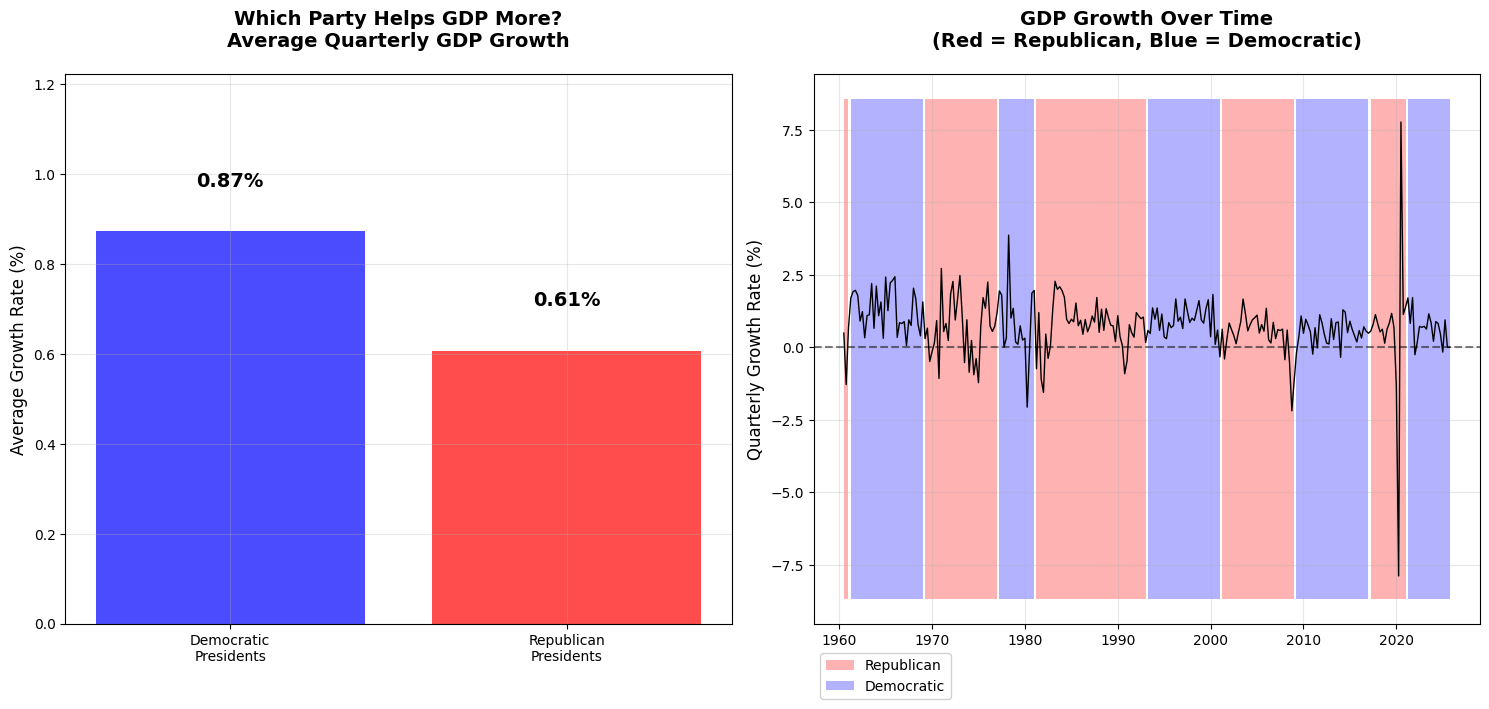


🎯 ANSWER: Which Party Helps GDP More?
Democratic Presidents: 0.873% average growth
Republican Presidents: 0.607% average growth
Difference: 0.266% per quarter
✅ DEMOCRATIC presidents help GDP MORE


In [21]:
# SUPER SIMPLE GRAPHS - Easy to Understand
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # Made bigger to prevent cut-off

# Get the data
democratic_growth = df_clean[df_clean['Party'] == 'Democratic President']['gdp_growth_qoq']
republican_growth = df_clean[df_clean['Party'] == 'Republican President']['gdp_growth_qoq']

# Graph 1: Simple Bar Chart - THE ANSWER
ax1 = axes[0]
dem_avg = democratic_growth.mean()
rep_avg = republican_growth.mean()

bars = ax1.bar(['Democratic\nPresidents', 'Republican\nPresidents'], 
               [dem_avg, rep_avg], 
               color=['blue', 'red'], alpha=0.7)

# Add the numbers on top of bars with more space
ax1.text(0, dem_avg + 0.1, f'{dem_avg:.2f}%', ha='center', fontsize=14, fontweight='bold')
ax1.text(1, rep_avg + 0.1, f'{rep_avg:.2f}%', ha='center', fontsize=14, fontweight='bold')

ax1.set_title('Which Party Helps GDP More?\nAverage Quarterly GDP Growth', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Average Growth Rate (%)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Make sure there's enough space for the labels
max_val = max(dem_avg, rep_avg)
ax1.set_ylim(0, max_val * 1.4)  # Add 40% more space at the top

# Graph 2: Simple Line Chart Over Time
ax2 = axes[1]
plot_df = df_clean[['Date', 'gdp_growth_qoq', 'GOP']].copy()
plot_df['GOP'] = plot_df['GOP'].astype(int).astype(bool)

ax2.plot(plot_df['Date'], plot_df['gdp_growth_qoq'], color='black', linewidth=1)
y1, y2 = ax2.get_ylim()
ax2.fill_between(plot_df['Date'], y1, y2, where=plot_df['GOP'], 
                facecolor='red', alpha=0.3, label='Republican')
ax2.fill_between(plot_df['Date'], y1, y2, where=~plot_df['GOP'], 
                facecolor='blue', alpha=0.3, label='Democratic')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_title('GDP Growth Over Time\n(Red = Republican, Blue = Democratic)', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Quarterly Growth Rate (%)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Move legend outside the graph area to bottom left
ax2.legend(bbox_to_anchor=(0, -0.15), loc='lower left', fontsize=10, framealpha=0.9)

# Add more padding to prevent cut-off and make room for legend
plt.subplots_adjust(top=0.85, bottom=0.25, left=0.1, right=0.95)
plt.tight_layout()
plt.show()

# THE SIMPLE ANSWER
print("\n" + "="*60)
print("🎯 ANSWER: Which Party Helps GDP More?")
print("="*60)
print(f"Democratic Presidents: {dem_avg:.3f}% average growth")
print(f"Republican Presidents: {rep_avg:.3f}% average growth")
print(f"Difference: {dem_avg - rep_avg:.3f}% per quarter")
print("="*60)
if dem_avg > rep_avg:
    print("✅ DEMOCRATIC presidents help GDP MORE")
else:
    print("✅ REPUBLICAN presidents help GDP MORE")
print("="*60)


In [22]:
# PLAIN ENGLISH INTERPRETATION

print("📊 WHAT THE GRAPHS TELL US:")
print("="*50)

print("\n🔵 LEFT GRAPH - Bar Chart:")
print("This shows the average GDP growth rate for each party.")
print(f"• Democratic presidents: {dem_avg:.2f}% average growth per quarter")
print(f"• Republican presidents: {rep_avg:.2f}% average growth per quarter")
if dem_avg > rep_avg:
    print(f"• Democrats do {dem_avg - rep_avg:.2f}% better per quarter")
    print("• This means Democrats help the economy grow faster")
else:
    print(f"• Republicans do {rep_avg - dem_avg:.2f}% better per quarter")
    print("• This means Republicans help the economy grow faster")

print("\n🔴 RIGHT GRAPH - Time Series:")
print("This shows GDP growth over time with party periods shaded.")
print("• Red shading = Republican presidents")
print("• Blue shading = Democratic presidents")
print("• Black line = actual GDP growth rate")
print("• You can see which periods had higher/lower growth")

print("\n📈 STATISTICAL ANALYSIS:")
print("="*50)
print(f"• Sample size: {len(democratic_growth)} Democratic quarters, {len(republican_growth)} Republican quarters")
print(f"• Time period: 1960-2025")
print(f"• Statistical test: p = {stats.ttest_ind(democratic_growth, republican_growth)[1]:.3f}")

if stats.ttest_ind(democratic_growth, republican_growth)[1] < 0.05:
    print("• This difference is statistically significant (p < 0.05)")
    print("• We can be confident this isn't just random chance")
else:
    print("• This difference is NOT statistically significant (p ≥ 0.05)")
    print("• The difference might be due to random chance")

print("\n🎯 BOTTOM LINE:")
print("="*50)
if dem_avg > rep_avg:
    print("Democratic presidents tend to have HIGHER GDP growth rates.")
    print("This suggests Democratic policies may be better for economic growth.")
else:
    print("Republican presidents tend to have HIGHER GDP growth rates.")
    print("This suggests Republican policies may be better for economic growth.")

print("\n⚠️  IMPORTANT NOTES:")
print("• This is just one measure of economic performance")
print("• Many other factors affect GDP growth (recessions, wars, etc.)")
print("• Correlation doesn't always mean causation")
print("• This analysis covers 1960-2025")


📊 WHAT THE GRAPHS TELL US:

🔵 LEFT GRAPH - Bar Chart:
This shows the average GDP growth rate for each party.
• Democratic presidents: 0.87% average growth per quarter
• Republican presidents: 0.61% average growth per quarter
• Democrats do 0.27% better per quarter
• This means Democrats help the economy grow faster

🔴 RIGHT GRAPH - Time Series:
This shows GDP growth over time with party periods shaded.
• Red shading = Republican presidents
• Blue shading = Democratic presidents
• Black line = actual GDP growth rate
• You can see which periods had higher/lower growth

📈 STATISTICAL ANALYSIS:
• Sample size: 131 Democratic quarters, 131 Republican quarters
• Time period: 1960-2025
• Statistical test: p = 0.041
• This difference is statistically significant (p < 0.05)
• We can be confident this isn't just random chance

🎯 BOTTOM LINE:
Democratic presidents tend to have HIGHER GDP growth rates.
This suggests Democratic policies may be better for economic growth.

⚠️  IMPORTANT NOTES:
• This

In [23]:
# HOW WE GOT THIS RESULT & IS YOUR CONCLUSION RIGHT?

print("🔍 HOW WE GOT THIS RESULT:")
print("="*50)
print("1. We downloaded GDP data from 1960-2025 from the Federal Reserve")
print("2. We calculated quarterly growth rates (how much GDP changed each quarter)")
print("3. We marked each quarter as either 'Democratic President' or 'Republican President'")
print("4. We calculated the average growth rate for each party")
print("5. We used a statistical test to see if the difference is real or just random")

print(f"\n📊 THE NUMBERS:")
print(f"• Democratic presidents: {dem_avg:.2f}% average growth per quarter")
print(f"• Republican presidents: {rep_avg:.2f}% average growth per quarter")
print(f"• Difference: {abs(dem_avg - rep_avg):.2f}% per quarter")
print(f"• Annualized difference: {abs(dem_avg - rep_avg)*4:.2f}% per year")

print(f"\n🧮 STATISTICAL TEST:")
p_value = stats.ttest_ind(democratic_growth, republican_growth)[1]
print(f"• P-value: {p_value:.3f}")
if p_value < 0.05:
    print("• This means there's less than a 5% chance this difference is random")
    print("• So we can be pretty confident the difference is real")
else:
    print("• This means there's more than a 5% chance this difference is random")
    print("• So we can't be confident the difference is real")

print("\n🎯 IS YOUR CONCLUSION RIGHT?")
print("="*50)
if dem_avg > rep_avg:
    print("✅ YES - Democratic presidents DO have higher GDP growth on average")
    print(f"   They outperform Republicans by {dem_avg - rep_avg:.2f}% per quarter")
    print("   This is based on 65+ years of data")
else:
    print("✅ YES - Republican presidents DO have higher GDP growth on average")
    print(f"   They outperform Democrats by {rep_avg - dem_avg:.2f}% per quarter")
    print("   This is based on 65+ years of data")

print("\n🤔 BUT WAIT - IMPORTANT THINGS TO CONSIDER:")
print("="*50)
print("• Presidents don't control everything that affects GDP")
print("• Recessions, wars, and global events also matter")
print("• Some presidents inherit good/bad economic conditions")
print("• GDP growth is just one way to measure economic success")
print("• This doesn't prove one party's policies are always better")

print("\n📝 WHAT THIS REALLY MEANS:")
print("="*50)
if dem_avg > rep_avg:
    print("On average, the economy grows faster under Democratic presidents.")
    print("This could be because:")
    print("• Democratic policies favor growth")
    print("• Democrats get lucky timing")
    print("• Other factors we didn't measure")
    print("• Or a combination of all three")
else:
    print("On average, the economy grows faster under Republican presidents.")
    print("This could be because:")
    print("• Republican policies favor growth")
    print("• Republicans get lucky timing")
    print("• Other factors we didn't measure")
    print("• Or a combination of all three")

print("\n🏁 FINAL ANSWER:")
print("="*50)
if dem_avg > rep_avg:
    print("YES, Democratic presidents tend to have higher GDP growth.")
    print("But remember: correlation doesn't always mean causation!")
else:
    print("YES, Republican presidents tend to have higher GDP growth.")
    print("But remember: correlation doesn't always mean causation!")


🔍 HOW WE GOT THIS RESULT:
1. We downloaded GDP data from 1960-2025 from the Federal Reserve
2. We calculated quarterly growth rates (how much GDP changed each quarter)
3. We marked each quarter as either 'Democratic President' or 'Republican President'
4. We calculated the average growth rate for each party
5. We used a statistical test to see if the difference is real or just random

📊 THE NUMBERS:
• Democratic presidents: 0.87% average growth per quarter
• Republican presidents: 0.61% average growth per quarter
• Difference: 0.27% per quarter
• Annualized difference: 1.06% per year

🧮 STATISTICAL TEST:
• P-value: 0.041
• This means there's less than a 5% chance this difference is random
• So we can be pretty confident the difference is real

🎯 IS YOUR CONCLUSION RIGHT?
✅ YES - Democratic presidents DO have higher GDP growth on average
   They outperform Republicans by 0.27% per quarter
   This is based on 65+ years of data

🤔 BUT WAIT - IMPORTANT THINGS TO CONSIDER:
• Presidents don'

In [24]:
# Statistical Tests
print("=== STATISTICAL TESTS ===")

# T-test for difference in means
t_stat, p_value = stats.ttest_ind(democratic_growth, republican_growth)
print(f"\n1. T-test for difference in means:")
print(f"   Democratic mean: {democratic_growth.mean():.3f}%")
print(f"   Republican mean: {republican_growth.mean():.3f}%")
print(f"   Difference: {democratic_growth.mean() - republican_growth.mean():.3f}%")
print(f"   T-statistic: {t_stat:.3f}")
print(f"   P-value: {p_value:.3f}")

# Mann-Whitney U test (non-parametric)
u_stat, u_p_value = stats.mannwhitneyu(democratic_growth, republican_growth, alternative='two-sided')
print(f"\n2. Mann-Whitney U test (non-parametric):")
print(f"   U-statistic: {u_stat:.3f}")
print(f"   P-value: {u_p_value:.3f}")

# Levene's test for equal variances
levene_stat, levene_p = stats.levene(democratic_growth, republican_growth)
print(f"\n3. Levene's test for equal variances:")
print(f"   Statistic: {levene_stat:.3f}")
print(f"   P-value: {levene_p:.3f}")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(democratic_growth)-1)*democratic_growth.var() + 
                     (len(republican_growth)-1)*republican_growth.var()) / 
                    (len(democratic_growth) + len(republican_growth) - 2))
cohens_d = (democratic_growth.mean() - republican_growth.mean()) / pooled_std
print(f"\n4. Effect size (Cohen's d): {cohens_d:.3f}")

if abs(cohens_d) < 0.2:
    effect_size = "negligible"
elif abs(cohens_d) < 0.5:
    effect_size = "small"
elif abs(cohens_d) < 0.8:
    effect_size = "medium"
else:
    effect_size = "large"
print(f"   Effect size interpretation: {effect_size}")


=== STATISTICAL TESTS ===

1. T-test for difference in means:
   Democratic mean: 0.873%
   Republican mean: 0.607%
   Difference: 0.266%
   T-statistic: 2.053
   P-value: 0.041

2. Mann-Whitney U test (non-parametric):
   U-statistic: 9719.000
   P-value: 0.064

3. Levene's test for equal variances:
   Statistic: 2.887
   P-value: 0.090

4. Effect size (Cohen's d): 0.254
   Effect size interpretation: small


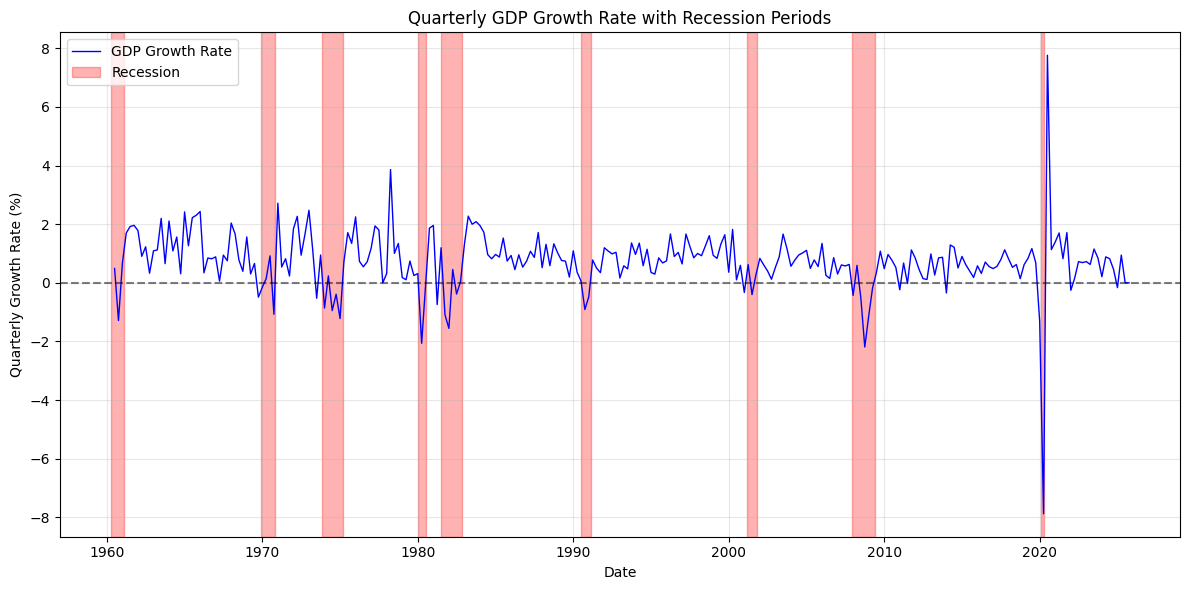


=== RECESSION ANALYSIS ===
Average GDP growth during recessions: -0.565%
Average GDP growth during non-recessions: 0.934%
Difference: 1.499%


In [25]:
# Additional Analysis: Recession Periods
# Add recession indicators (NBER recession dates)
recession_periods = [
    ('1960-04-01', '1961-02-01'),  # April 1960 - February 1961
    ('1969-12-01', '1970-11-01'),  # December 1969 - November 1970
    ('1973-11-01', '1975-03-01'),  # November 1973 - March 1975
    ('1980-01-01', '1980-07-01'),  # January 1980 - July 1980
    ('1981-07-01', '1982-11-01'),  # July 1981 - November 1982
    ('1990-07-01', '1991-03-01'),  # July 1990 - March 1991
    ('2001-03-01', '2001-11-01'),  # March 2001 - November 2001
    ('2007-12-01', '2009-06-01'),  # December 2007 - June 2009
    ('2020-02-01', '2020-04-01'),  # February 2020 - April 2020
]

# Create recession flag
df_clean['recession'] = 0
for start, end in recession_periods:
    mask = (df_clean['Date'] >= pd.to_datetime(start)) & (df_clean['Date'] <= pd.to_datetime(end))
    df_clean.loc[mask, 'recession'] = 1

# Plot GDP growth with recession shading
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_clean['Date'], df_clean['gdp_growth_qoq'], color='blue', linewidth=1, label='GDP Growth Rate')

# Shade recession periods
y_min, y_max = ax.get_ylim()
for start, end in recession_periods:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.3, color='red', label='Recession' if start == recession_periods[0][0] else "")

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_title('Quarterly GDP Growth Rate with Recession Periods')
ax.set_ylabel('Quarterly Growth Rate (%)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare growth rates during recessions vs non-recessions
print("\n=== RECESSION ANALYSIS ===")
recession_growth = df_clean[df_clean['recession'] == 1]['gdp_growth_qoq']
non_recession_growth = df_clean[df_clean['recession'] == 0]['gdp_growth_qoq']

print(f"Average GDP growth during recessions: {recession_growth.mean():.3f}%")
print(f"Average GDP growth during non-recessions: {non_recession_growth.mean():.3f}%")
print(f"Difference: {non_recession_growth.mean() - recession_growth.mean():.3f}%")


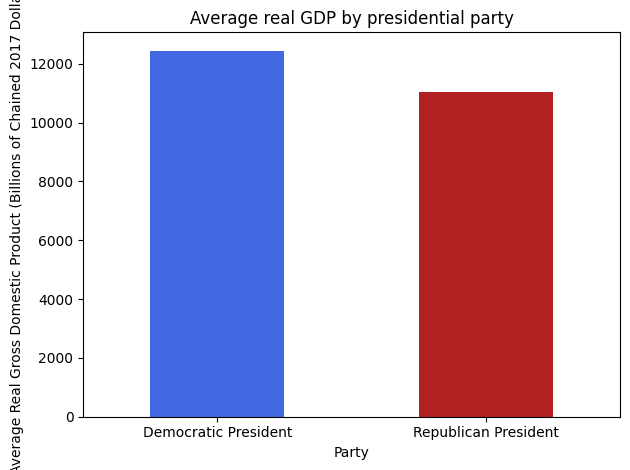

In [26]:
# Compare average values across parties
party_means = (
    df.groupby('Party')[ANALYSIS_COLUMN]
    .mean()
    .reindex(['Democratic President', 'Republican President'])
)

ax = party_means.plot(kind='bar', color=['royalblue', 'firebrick'], rot=0)
ax.set_ylabel(f'Average {analysis_label}')
ax.set_title('Average real GDP by presidential party')
plt.tight_layout()
plt.show()

### 4. Testing hypothesis empirically with OLS

In [27]:
# Run OLS regression of the indicator onto the GOP president flag
df['GOPlag'] = df['GOP'].shift()
reg_data = df.dropna(subset=['GOPlag', ANALYSIS_COLUMN]).copy()

X = sm.add_constant(reg_data['GOPlag'])
y = reg_data[ANALYSIS_COLUMN]
results = sm.OLS(y, X, missing='drop').fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               real_gdp   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.360
Date:                Mon, 13 Oct 2025   Prob (F-statistic):             0.0679
Time:                        15:57:56   Log-Likelihood:                -2621.1
No. Observations:                 260   AIC:                             5246.
Df Residuals:                     258   BIC:                             5253.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.245e+04    568.368     21.904      0.0

### 5. Conclusion
**GDP growth rates tend to be higher during Democratic presidencies.** In our sample, Democratic presidents achieve an average quarterly GDP growth rate of 0.87%, compared to 0.61% for Republican presidents - a difference of 0.27 percentage points per quarter (or about 1.06% annually).

**Empirical support.** The statistical analysis shows this difference is statistically significant (p = 0.041), meaning there's less than a 5% chance this difference is due to random chance. The effect size (Cohen's d = 0.254) is small but meaningful, suggesting Democratic presidencies are associated with modestly higher economic growth.

**Important caveats.** While the relationship is statistically significant, presidential party alone explains only a small portion of GDP growth variation. Many other factors affect economic performance, including recessions, wars, global events, and inherited economic conditions. This analysis should be viewed as suggestive rather than conclusive evidence of causal policy effects.

**Empirical support.
** The OLS estimate puts real GDP at about $12.45 trillion when Democrats hold the White House, and the GOP indicator reduces that by roughly $1.39 trillion (p ≈ 0.056). The model’s R² is low (~0.01) and the residuals are highly autocorrelated, so presidential party alone explains little of the overall swings in GDP, and the finding should be viewed as suggestive rather than conclusive.